# Lecture 2: Statistical Distributions and Stochastic Processes

The last lecture was focused on "introducing" the core concepts of inferential and descriptive statistics and overall how statistics could be used in finance. In the case of Risk Management, one is very often concerned with modeling profit/loss data with various distributions and stochastic processes. This lecture will go through the most common types of statistical distributions and processes that one would encounter in Quantitative Risk Management.

The main topics of discussion are the following:

 1. Probability Distributions in $\mathbb{R}^+$ and $\mathbb{R}^+_0$
 2. Multivariate Distributions
 3. Copulas
 4. Stochastic Processes
 
Note: $\mathbb{R}^+$ represents the positive real line and $\mathbb{R}^+_0$ represents the non-negative real line.

In [1]:
#Importing standard libraries

import numpy as np
from matplotlib import pyplot as plt 
import scipy as sci
import pandas as pd

## Probability Distributions in $\mathbb{R}^+$ and $\mathbb{R}^+_0$

This section will present several probability distributions that one will encounter and should consider when doing QRM. For every distribution, I will present the probality density function (PDF), give an example of where it is commonly used, and implement it in python. Note that all of these distributions could be found in the `scipy.stats` and I really encourage you to read through at least one of the docs (e.g `scipy.stats.beta`). Also, for more info on a specific distribution, Wikipedia seems to be accurate for these types of things.

### Beta Distribution

In insurance calculations, a very common tool used to model risk and claim sizes are right skewed distributions. A common example is the beta distribution. The beta distribution, $P(x|\alpha,\beta)$, is a probability distribution defined only on $x \in (0,1)$ and $\alpha,\beta > 0$ that is defined as follows:

$$P(x|\alpha,\beta) = \frac{1}{B(\alpha,\beta)}x^{\alpha - 1}(1 - x)^{\beta - 1}$$


where $B(\alpha,\beta)$ is a normalizing constant that ensures that the integral of the un-normalized probability density function across all space, $(0,1)$, is 1 (i.e net probability is 1), or

$$B(\alpha,\beta) = \int_0^1 x^{\alpha - 1}(1 - x)^{\beta - 1} dx$$

One can find more relevant information on the [Wiki Page](https://en.wikipedia.org/wiki/Beta_function).



Note that to define $P(x|\alpha,\beta)$ in $\mathbb{R}^+$, one can simply say that $P(x|\alpha,\beta) = 0$ if $x \notin (0,1)$.



If a dataset $X$ follows a beta distribution, one can compute the expectation value $\mathbb{E}$ as

$$\mathbb{E}(\alpha,\beta) = \frac{\alpha}{\alpha + \beta}$$

and the variance $\sigma^2$ as

$$\sigma^2 = \frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta + 1)}$$


Beta distributions are very useful because as will be shown in a bit, by varying the shape parameters $\alpha$ and $\beta$, one can vary the _beliefs_ about $X$ substantially

#### Python Implementation

In [2]:
##Defining a beta PDF

from scipy import integrate as integrate #Importing scipy's integration library

def beta_pdf(x,alpha,beta):
    beta_not_norm = lambda x: x**(alpha - 1)*(1-x)**(beta - 1) #Defining unnormalized beta 
    B = integrate.quad(beta_not_norm,0, 1) #calculating the norm constant
    return beta_not_norm(x)/B[0]#multiplying beta with scaling constant (making it normalized)

beta_pdf(0.5,0.5,0.5)

##NOTE: YOU CAN ACCOMPLISH THE SAME THING USING SCIPY -- NO NEED TO GO THROUGH THE TROUBLE
##from scipy.stats import beta

0.6366197723675625

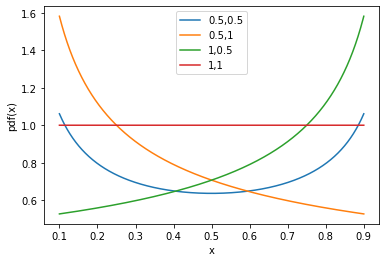

In [3]:
params = [0.5,1] #defining the parameters we want to test
x = np.linspace(0.1,0.9,10000) #Defining the space (I use (0.1,0.9) rather than(0,1)because it makes the graph neater) 

for i in params: #looping on alpha vals
    for j in params: #looping on beta vals
        plt.plot(x,beta_pdf(x,i,j),label=str(i)+","+str(j)) #plotting the function we defined above on the space x
        
plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.legend()

By looking at the figure above, one can see several different types of functions. When both $\alpha$ and $\beta$ are 1, a uniform probability distribution is generated, when the params are (0.5,1) a decaying function is generated. In other words, by varying $\alpha$ and $\beta$, one can dramatically vary the _beliefs_ of the distribution.

$\beta(2,5)$ is a more clear demonstration of a right-wing distribution, as shown in the code block bellow:

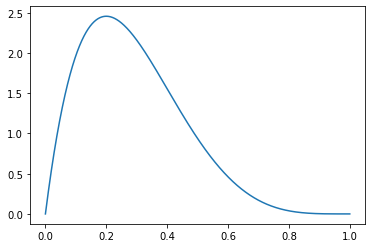

In [4]:
x = np.linspace(0,1,10000)
plt.plot(x,beta_pdf(x,2,5))

### Burr XII Distributions

Another distribution used in risk managment (e.g when modeling household income) is the Burr12 distribution. It is a three parameter distribution defined on $\mathbb{R^+_0}$ by the following PDF:

$$P(x|c,k,\lambda) = \frac{ck}{\lambda}\left(\frac{x}{\lambda}\right)^{c-1}\left[1 + \left(\frac{x}{\lambda}\right)^{c}\right]^{-k-1}$$


where $c,k, \lambda > 0$.


It is also sometimes defined by two parameters (by setting $\lambda = 1$), the result will be:

$$P(x|c,k,\lambda) = \frac{ckx^{c-1}}{(1 + x^{c})^{k+1}}$$


#### Python Implementation:

Note: I will not be building this PDF from scratch but will rather use scipy's `scipy.stats.burr12` (which uses the 2 parameter definition). You that you can do the same for Beta distributions by using `scipy.stats.beta`.


In [5]:
from scipy.stats import burr12 

burr12.pdf(1,3,1.5)

0.7954951288348661

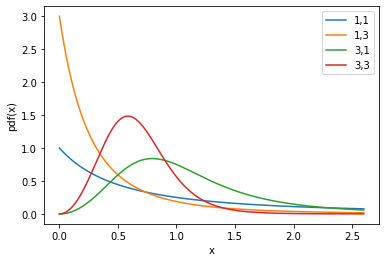

In [6]:
x = np.linspace(0,2.6,10000) #The burr12 distribution is defined for positive numbers

params = [1,3] #params were gonna use

for i in params: #looping for c
    for j in params: #looping for k
        plt.plot(x,burr12.pdf(x,i,j),label=str(i)+","+str(j)) #plotting the pdf
        
plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.legend()

### Inverse Gaussian/Wald Distribution


The inverse Guassian distribution, $invN$, is a two parameter distribution with defined on $\mathbb{R^+}$ by the following PDF:

$$P(x|\lambda,\mu) = \left(\frac{\lambda}{2\pi x^3}\right)^{1/2}e^{-\lambda(x - \mu)^2 / 2\mu^2x}$$


where $\lambda,\mu>0$. 

Suppose $X \sim invN(\lambda, \mu)$, then the expectation value of $X$ is

$$\mathbb{E}[X] = \mu$$ 

and the variance of $X$ is 

$$\sigma^2[X] = \mu^3 / \lambda$$


If you invert every element of $X$ with respect to multiplication $X \rightarrow \frac{1}{X}$, then the following holds:

$$\mathbb{E}[\frac{1}{X}] = 1/\mu + 1/\lambda$$ 

and 

$$\sigma^2[\frac{1}{X}] = 1/\mu\lambda + 2/\lambda^2$$



This distribution is very commonly used for modeling credit risk losses.

#### Python Implementation:

In [7]:
from scipy.stats import invgauss #Takes only mu as a parameter

invgauss.pdf(1,1)

0.3989422804014327

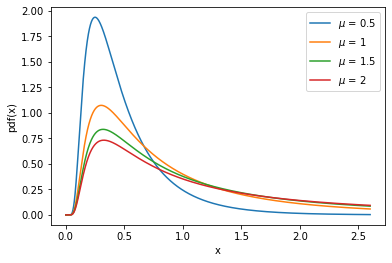

In [8]:
x = np.linspace(0,2.6,10000) #The invgauss distribution is defined for positive numbers

params = [0.5,1,1.5,2] #params were gonna use

for i in params: #looping for mu
    plt.plot(x,invgauss.pdf(x,i),label="$\mu$ = "+str(i)) #plotting the pdf
        
plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.legend()

Suppose x represents a loss. As one can see, the lower $\mu$, the more localized the probability of losses are and the more likely they are at a number near 0. In all cases, $\lim_{x \rightarrow \infty}Pr(x) = 0$, i.e the probability of very large losses tends to 0 (the effect is stronger for low $\mu$).

### Log-Normal Distribution


If you take the log of a normal distribution, you get a distribution, $\mathcal{LN}(\mu,\sigma)$ which has a PDF defined on $\mathbb{R^+}$ by:

$$P(x|\mu,\sigma) = \frac{1}{x}\frac{1}{\sigma\sqrt{2\pi}}\exp\left({-\frac{(\ln x - \mu)^2}{2\sigma^2}}\right)$$



In the [Black-Scholes Model](https://www.investopedia.com/terms/b/blackscholes.asp) of option pricing, asset prices are assumed to be log-normally distributed (as returns are assumed to be normally distributed). 



In [9]:
#Note: Using the PDF here is slightly different than the previous one... although it is still simple. 

from scipy.stats import lognorm 

def lognorm_pdf(x, mu, sigma):
    shape  = sigma
    loc    = 0
    scale  = np.exp(mu)
    return lognorm.pdf(x, shape, loc, scale)

lognorm_pdf(2, 2.05, 3)

0.060025936551821445

Text(0, 0.5, 'pdf(x)')

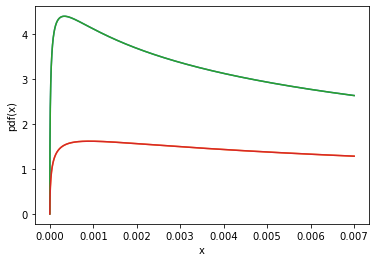

In [10]:
x = np.linspace(0.0,0.007,10000) #The lognormal distribution is defined for positive numbers

params = [1,2] #params were gonna use

for i in params: #looping for mu
    for i in params: #looping for sigma
        plt.plot(x,lognorm_pdf(x,i,j)) #plotting the pdf
        
plt.xlabel('x')
plt.ylabel('pdf(x)')


NOTE: FIX THIS CODE ITS FUCKING WRONG

### Pareto and Weibull Distribution


The _80/20_ rule has become a ubiquitous proverb in popular culture that essentially states the following: _In many cases, 80% of outcomes come from 20% of causes_. Examples include "80% of a company's productivity will come from 20% of employees", "80% of the knowledge you have will come from 20% of the time you spent studying", and two that are more relevant to finance, "80% of a society's wealth is possessed by 20% of its people" and "80 percent of a VC firm's returns will come from 20% percent of invested startups". Whilst its colloquial usage is not very scientifc, it roughly holds in certain scenarios, namely scenarios that can be accurately modeled by Pareto distributions. 


A Pareto distribution takes two parameters, $\alpha, d > 0$ and has a PDF defined on $x ≥ d$ by

$$P(x|\alpha,d) = \frac{\alpha d^\alpha}{x^{\alpha + 1}}$$

The expected value $\mathbb{E}[X]$ is defined only when $\alpha > 1$. It is equivalent to 

$$\mathbb{E}[X] = \frac{\alpha d}{\alpha - 1},  \alpha > 1$$

and the variance $\sigma^2$ is defined only when $\alpha > 2$ by

$$\sigma^2[X] = \left(\frac{d}{\alpha - 1}\right)^2\frac{\alpha}{\alpha - 2}$$


To prove that $\mathbb{E}[X]$ and $\sigma^2[X]$ are only defined in $\alpha \in (1,\infty)$ and $\alpha \in (2,\infty)$ respectively, one must show that they equal $\infty$ otherwise. 

Patero distributions are very common in modeling losses which exceed some threshold $d$.

<br>

There exists a very similar distribution called the Weibull Distribution. It is very common in studies such as fracture analysis in engineering and survival analysis. The Weibull distribution also takes two parameters and has a PDF defined by

$$P(x|\beta,\delta) = \frac{\delta}{\beta^\delta}(x^{\delta - 1})e^{-(x/\beta)^\delta}$$

for $x ≥ 0$ and $\beta, \delta > 0$.


These distributions are very crucial for the relevant field of Extreme Value Theory (which will be covered in Lecture 8). EVT is concered with high standard deviation regions of a probability distributions (e.g extreme losses due to a black swan event).

#### Python Implementation

In [11]:
from scipy.stats import pareto 

pareto.pdf(4,2,3) ##pdf where x = 4, alpha = 2 and threshold d = 3

2.0

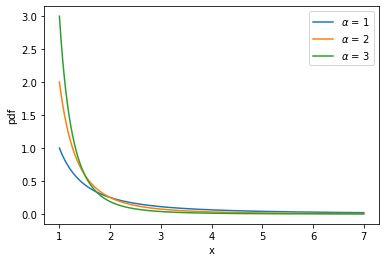

In [12]:
x = np.linspace(1,7,10000)
for j in range(1,4):
    plt.plot(x,[pareto.pdf(i,j) for i in x], label=r'$\alpha$ = '+ str(j)) #plotting alpha = 1,2,3 with default d = 1

plt.xlabel('x')
plt.ylabel('pdf')
plt.legend()

Mathematically, this "80/20 principle" translates to "the integral of the PDF between 0 and 20 percent of the domain  is equal to 80 percent of the total integral". Let's try it out on $\alpha = 3, d = 1$ with domain $x \in (1,7)$. In this case $20\%*(7-1) = 1.2$, meaning that if the rule is correct, 

$$\int^{2.2}_1 P(x|3,1)dx \approx 0.8*\int^{7}_1 P(x|3,1)dx$$


Let's use the `scipy.integrate.quad` function (which we've already imported) to find out. 

In [13]:
def pareto31(x):
    return (3)/(x**(3+1)) ##PDF of pareto(3,1)
    
integrate.quad(pareto31,1,2.2)[0]/integrate.quad(pareto31,1,7)[0]

0.9087350231325872

Well for $P(x|3,1)$ in $(1,7)$, it's more like the "90/10 principle" -- note that this is a bit of a gag and not based on serious mathematics, but it does demonstrate where the 80/20 rule comes from (and why people use it to explain phenomena such as wealth gaps).

### Example: Modeling [Insert Financial Dataset]

## Multivariate Distribution

In the previous section, several one dimensional probability distributions were introduced. Some that are effective for insurance mathematics, others for option pricing, and some that are common across many areas of QRM. This section will also be concerned with probability distributions, but of a different kind. As the title suggests, we will be covering multivariate distributions, or distributions that model two or more independent statistical variables.


### Multivariate Normal Distribution

The univariate normal distribution is arguably the most well known statistical distribution that has the following PDF:

$$P(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-(x-\mu)^2/2\sigma^2}$$

with mean $\mu$ and variance $\sigma^2$

The multivariate normal distribution  is a generalization of this to multiple dimensions (for example, rolling 4 fair dice and summing up two of the results with eachother yeilds a 2D normal distribution). The multivariate normal distribution describes a joint distribution of random variables $X_1, \dots, X_p$ that could be stochastically dependent (i.e the value of variable $i$ affects the probability distribution of the outcomes of varaible $j$ where $i \neq j$)


Given a vector of random variables $\vec{X} = \{X_1, \dots, X_p\} \in \mathbb{R}^p$ that follow a multivariate normal distribution, then the distribution could be uniquely described by an expectation value vector $\vec{\mu} \in \mathbb{R}^p$

$$\vec{\mu} = \{\mu_1,\dots,\mu_p\}$$

and a covariance matrix $\mathbf{\Sigma} \in (-1,1)^{p\times p}$


$$\mathbf{\Sigma} = \begin{pmatrix}\sigma_{11} & \dots & \sigma_{1p} \\ \vdots & \ddots & \vdots \\ \sigma_{p1} & \dots & \sigma_{pp}\end{pmatrix}$$


For example, a 2D multivariate normal distribution could be completely described by the following parameters: $\{\mu_1, \mu_2, \sigma_1, \sigma_2, Cov(1,2)\}$ where the first two are encoded into $\vec{\mu}$ and the latter three are encoded into $\mathbf{\Sigma}$ (where the diagonals represent the standard deviations). 



The multivariate normal distribution could be described on $\vec{x} \in \mathbb{R}^p$ by following PDF:

$$P(\vec{x}|\vec{\mu},\mathbf{\Sigma}) = \frac{1}{\sqrt{(2\pi)^p \det{\mathbf{\Sigma}}}}\exp{\left(-\frac{1}{2}(\vec{x} - \vec{\mu})^T\mathbf{\Sigma}^{-1}(\vec{x} - \vec{\mu})\right)}$$

where $(.)^T$ denotes the transpose operation $M_{ij}\rightarrow M_{ji}$ and

$$\mu_j = \mathbb{E}[X_j]$$
$$\sigma_{jj} = Var(X_j)$$
$$\sigma_{ij} = Cov(X_i,X_j)$$


#### Python Implementation

Here we're going to 4 dice -- call them $X_1,X_2,X_3,X_4$ and will then proceed to map these four variables to $Y_1 = X_1 + X_2$ and $Y_2 = X_3 + X_4$. We will then fit that to a multivariate normal distribution and plot it. Essentially a 2 dimensional version of what was done in Lecture 1.

##### Step 1: Get the data

In [14]:
from numpy.random import randint #random integer generator

def roll_dice():
    return randint(1,7) #random number generator between 1 and 6 -- effectively a fair dice

Y1 = [roll_dice() + roll_dice() for i in range(1000)] #samples X_1 + X_2 1000 times
Y2 = [roll_dice() + roll_dice() for i in range(1000)] #samples X_3 + X_4 1000 times


mu_vec = np.array([np.mean(Y1),np.mean(Y2)]) #mu vector
sigma_mat = np.cov(Y1,Y2) ##covariance matrix

##### Step 2: Generate Multivariate normal distribution P($\vec{x}|\vec{\mu},\mathbb{\Sigma}$)

In [15]:
x = np.random.uniform(size=(10000, 2))*13 #Defining our x,y axis by 10000 points

pdf = sci.stats.multivariate_normal.pdf(x,mu_vec, sigma_mat) #getting the pdf
pdf

array([3.41693236e-04, 2.72373929e-03, 1.59220194e-03, ...,
       9.80574379e-04, 2.99232182e-03, 9.40036030e-06])

##### Step 3: Plotting the output

Text(0.5, 0, '$P(\\vec{Y})$')

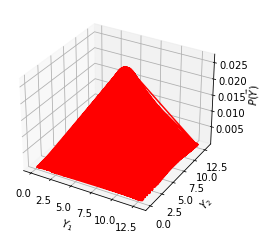

In [16]:
fig = plt.figure() 
ax = plt.axes(projection='3d') #setting up a 3d plot

ax.plot3D([x[i][0] for i in range(10000)],[x[i][1] for i in range(10000)], pdf, 'red') #plotting the pdf 
ax.set_xlabel('$Y_1$')
ax.set_ylabel('$Y_2$')
ax.set_zlabel(r'$P(\vec{Y})$')

As you can see we get the desired output (which, as the number of samples of $Y_1$ and $Y_2 \rightarrow \infty$, should more and more accurately model the data, as per the central limit theorem)!


Note that all marginal distributions (or sub-distributions) should also follow a multivariate normal distribution, or

$$X_i \sim N(\mu_i,\sigma_{ii})$$

for $X_i \in \vec{X}$. 

Also, if we divide $\vec{X} = \{X_1,\dots, X_p\}$ into two vectors $X^{(1)} = \{X_1,\dots, X_i\}$ and $X^{(2)} = \{X_i,\dots, X_p\}$ where $1 < i < p$, then 

$$\begin{pmatrix}X^{(1)} \\ X^{(2)}\end{pmatrix} \sim N\left(\begin{pmatrix}\mu^{(1)} \\ \mu^{(2)}\end{pmatrix},
\begin{pmatrix}\mathbf{\Sigma}^{(11)} & \mathbf{\Sigma}^{(12)} \\ \mathbf{\Sigma}^{(21)} & \mathbf{\Sigma}^{(22)}\end{pmatrix}\right)$$



Another important property is that if $\vec{X} \in \mathbb{R}^p$ follows a multivariate normal distribution, then any linear combination of $X$ also follows a normal distribution. i.e


$$\mathbf{A}\vec{X} + \vec{b} \sim N(\mathbf{A}\vec{\mu} + \vec{b}, \mathbf{A}\mathbf{\Sigma}\mathbf{A}^T)$$

where $\mathbf{A} \in \mathbb{R}^{p \times p}$ and $\vec{b} \in \mathbb{R}^p$


### Multinomial Distribution


Another well-known univariate distribution that we will generalize is the binomial distribution. The binomial distribution is used to describe the number of successes in $n$ independant boolean-outcomed experiments (e.g flipping a coin $n$ number of times). The probability is given by 

$$P_x = \begin{pmatrix}n \\ x\end{pmatrix}p^xq^{n-x}$$

with $\begin{pmatrix}n \\ x\end{pmatrix}$ being the number of combinations, $p$ is the probability of success in a single try, and $q = 1-p$ is the probability of failure in a single trial. 

Say you want to study the probability of randomly selecting a combination of genders of students in a university. If you go to some religiously-affiliated university, a binomial distribution will be sufficient given that the students will either be male or female. However, by going to a left winging liberal arts school, where many students might identify as a non-binary gender, a binomial distribution will not suffice and you would rather require some generalization that allows one to have more than two possible outcomes (e.g he,her,them,etc.). Such a distribution is called the multinomial distribution. 

Given possible outcomes $a_1,\dots,a_k$ which have respective probabilities $p_1,\dots,p_k$, then 

$$X = (X_1,\dots,X_k) \sim Multinom(n;p_1, \dots,p_k)$$

where $X_i$ denotes the number of successes for outcome $a_i$. 


Given $(x_1, \dots,x_k) \in \mathbb{N}^k$ with $\sum_{i = 1}^k x_i = n$, The probability function for the multinomial distribution is


$$\mathbb{P}(X_1 = x_1, \dots, X_k = x_k) = \begin{pmatrix}n! \\ x_1! \dots x_k!\end{pmatrix} p_1 ^{x_1} \dots p_k ^{x_k}$$


#### Python Implementation

Let's try to simulate a bunch of fair dice

In [17]:
from numpy import random

def fair_dice(n):
    return random.multinomial(n=n, pvals=[1/6]*6) #returns n fair dice

for i in range(1,6):
    print("Rolling a dice ",str(20*i),"times returns the following counts: ",fair_dice(20*i))

Rolling a dice  20 times returns the following counts:  [4 4 4 1 2 5]
Rolling a dice  40 times returns the following counts:  [5 7 9 7 6 6]
Rolling a dice  60 times returns the following counts:  [13 11 11  9  9  7]
Rolling a dice  80 times returns the following counts:  [ 7 14 13 13 14 19]
Rolling a dice  100 times returns the following counts:  [13 17 17 17 15 21]


## Copulas

As mentioned above, the marginal distributions of a multivariate normal distribution are also normal distributions, but is the opposite true? Do a set of univariate normal distributions form a joint multivariate normal distribution? This could be answered using copulas, a tool that very generally describes the relationship between marginal distributions and multivariate distributions. (the answer is no, by the way)

Note: this section is heavily influenced (and is in fact, sometimes directly copied from) by the following two documents: 

 [1] http://www.columbia.edu/~mh2078/QRM/Copulas.pdf
 
 [2] https://www.angelfire.com/falcon/isinotes/mult/cop1.pdf
 
 I  highly recommend the ambitious reader to go through them for a more comprehensive introduction, and also recommend everyone to watch the following video for a simpler view:
 
 [![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/R_7Qvbrb0jE/0.jpg)](https://www.youtube.com/watch?v=R_7Qvbrb0jE)

### Motivation/Definition

One of the central problems in QRM is studying the risk of a given portfolio, which is not only concerned with modeling the marginal distributions but rather also with the modeling of the dependence structure of the individual risk factors. Many models such as CCC- and DCC-GARCH use **linear** correlations to describe the dependence structure. However, it is not necessary that the dependence structure is linear, and concequently not necessary that linear correlations are an effective way to describe the dependence structure. This issue could be resolved using Copulas, which is defined as follows:

A $d-$dimensional copula $C(\vec{u}) = C(u_1,\dots,u_d)$ is a distribution function on a $d-$dimensional hypercube $[0,1]^d$ with univariate marginal distributions that are uniformly distributed on $[0,1]$. By definition, $u_i \in [0,1]$. In the simplest terms, a copula maps a set of input marginal probabilities into a joint probability.

The following are examples of 2D copulas:

<img src="assets/normal_plots.png" width=400>


A more formal definition of copulas is the following:

The function $C: [0,1]^d \rightarrow [0,1]$ is a $d$-copula iff:

   1. $C(u_1, \dots, u_d)$ is monotonically increasing
   2. $C(1,\dots,1,u_i,1,\dots,1) = u_i$ for $i \in {1,\dots,d}$ and $u_i \in [0,1]$
   3. For all $(a_1,\dots,a_d)$, $(b_1,\dots,b_d) \in [0,1]^d$ with $a_i ≤ b_i$ we have:
   
   $$\sum_{i_1 = 1}^2 \dots \sum_{i_d = 1}^2 (-1)^{i_1 + \dots + i_d}C(u_{1i_1}, \dots, u_{di_d}) ≤ 0$$
   
   where $u_{j1} = a_i$ and $u_{j2} = b_i$ for all $j \in \{1,\dots, d\}$
   
<br>


 - The first condition is satisfied by any distribution function. This could be proven by the following statement: $P(A_1 ∪ A_2) ≥ P(A_1)$ 

 - The second condition reflects the constraint that the margins are uniformally distributed

 - The third property ensures that if $(U_1,\dots,U_d)^T$ is distributed according to a copula $C$, then $P(a_1≤U_1≤b_1, \dots, a_d≤U_d≤b_d)≥ 0 $

 - The bi and multivariate margins of a copula are also copulas
 

<br>

Given a distribution $G$, let $G^{\leftarrow}$ denote the generalized inverse (or [quantile function](https://en.wikipedia.org/wiki/Quantile_function)) of $G$. Then the following propositions are useful:

 1. Probability integral transform: If a random variable $Y$ has a continuous univariate distribution $G$, then
 
 $$G(Y) \sim U(0,1)$$
 
 where $U(0,1)$ denotes a uniform distribution between 0 and 1
 
 <br>
 <br>
 
 2. Quantile transform: If $U \sim U(0,1)$ applies, then
 
 $$P(G^{\leftarrow}(U) ≤ x) = G(x)$$
 
 
### Sklar's Theorem


Sklar's theorem: given a set of random varialbles $(x_1, \dots, x_d)$ with marginal commulative distribution functions $(F_1(x_1), \dots, F_d(x_d))$, as well as a joint distribution $F(x_1,\dots, x_d)$, then the relationship between $F$ and $(F_1, \dots, F_d)$ is a copula $C: [0,1]^d \rightarrow [0,1]$, or 

$$F(x_1,\dots,x_d) = C(F_1(x_1),\dots,F_d(x_d))$$
 
Also, if the marginal distributions are continuous, then C is unique. In other words, every continuous joint distribution includes a copula, which you can estimate (using methods like MLE) to use along with the marginal distributions to estimate the joint distribution. 

Note: now would be a good time to revisit the first sentence written about copulas above


Two important points come as a concequence of Sklar's theorem. The first is that given a joint distribution, a capula $C$ will suffice to completely describe the dependence structure between the marginal distributions. The second is that copulas can be used to generate high-dimensional distributions from any set of marginal distributions (whether they belong to the same family of distributions or not). Both of these points have very powerful use cases in finance (for example, their misuse is arguably what lead to the 2008 financial crisis, as we'll discuss later). Sklar's theorem, however, does not make any statements about how to use copulas or their form, it just asserts its existance.

<hr>

There are two main properties of copulas that one might find useful: 

 - They are invariant under monotonic transformations: Suppose the random variables $X_1, \dots, X_d$ have continuous marginal distributions and copula $C$. Let $T_i$ : $\mathbb{R} \rightarrow \mathbb{R}$ for $i \in \{1,\dots,d\}$ be strictly monotonically increasing functions, then the dependance structure of the random variables 
 
 $$Y_1 = T_1(X_1) = \dots = T_d(X_d)$$
 
 is also given by copula $C$
 
 - The copula is also bounded by the _Frechet-Hoeffding_ bound: Any given copula $C(u_1,\dots,u_d)$ is bound by 
 
 $$\max\left\{1 - d + \sum_{i=1}^d u_i , 0\right\} \leq C(u_1, \dots, u_d) \leq \min\{u_1, \dots, u_d\}$$
 
 
 ### Types of Copulas
 
The previous section introduced the idea of a copula and stated a few theorems and propositions. This section will be more concrete and will be concerned with introducing several types of copulas. 

 ##### Independent Copula
 
 The most basic copula is one that is fortunately very intuitive, say we are given a set of $d$ independent variables with marginal probabilities $u_1, \dots,u_d$, then their joint probability is their products. The independent copula reflects that as follows:
 
 $$Π(u_1,\dots,u_d) = \prod_{i=1}^d u_i$$
 
 
 ##### Comonotonic Copula
 
The upper Frechet-Hoeffding bound

$$M(u_1,\dots,u_d) = \min\{u_1,\dots,u_d\}$$

yields a comonotonic copula. It represents a perfect positive dependence of the margins


 ##### Countermonotonic Copula
 
 
The lower Frechet-Hoeffding bound

$$W(u_1,u_2) = \max\{u_1 + u_2 - 1, 0\}$$

is only defined for $d = 2$ and represents a perfect negative dependence of the margins.

The first three copulas presented are examples of elementary copulas, or copulas that can be derived merely from the Frechet-Hoeffding bounds. However, in QRM, the most commonly used copulas are _elliptical copulas_, which are derived implicitly from elliptical multivariate distributions, for which the margins are elliptically distributed.

 ##### Gaussian Copula
 
 Let $\vec{Y} \sim N_d(\vec{\mu},\mathbf{\Sigma})$ be a normally distributed random variable with correlation $P$, then its corresponding unique copula is implicitly defined by 
 
 $$C_P^{Gauss}(\vec{u}) = \Phi_P(\phi_1^{-1}(u_1),\dots,\phi_d^{-1}(u_d))$$
 
 where $\mathbf{\Phi}$ denotes the joint CDF and $\phi_i^{-1}$ denotes the inverse of the $i$-th marginal normal distribution's CDF. As mentioned above, it is implicitly defined and cannot be written analytically, and rather by numerical integration.
 
 
 The Gaussian Copula has the $\frac{d(d-1)}{2}$ entries of the correlation matrix as parameters.
 
 **Simulating Gaussian Copula:**
 
  1. For an arbitrary covariance matrix, $\mathbb{\Sigma}$, let $P$ be its corresponding correlation matrix
  2. Compute the  Cholesky decomposition, $A$, of $P$ where $P = A^TA$
  3. Generate $\vec{Y} \sim N_d(\vec{0},\mathbf{I})$
  4. Set $X = A^TY$
  5. Return $U = (\phi_1(u_1),\dots,\phi_d(u_d))$
  
  The distribution of $U$ is the Gaussian copula $C_P^{Gauss}(\vec{u})$ so that
  
  $$P(U_1 \leq u_1, \dots, U_d \leq u_d) = \Phi_P(\phi_1^{-1}(u_1),\dots,\phi_d^{-1}(u_d))$$
  
  
  ##### The $t$-copula
  
  $\vec{X} = (X_1, \dots, X_d)$ has a multivariate $t$ distribution with $\nu$ degrees of freedom if 
  
  $$\vec{X} = \frac{\vec{Z}}{\sqrt{\xi/\nu}}$$
  
  
  where $Z \sim N_d(\vec{0}, \mathbf{\Sigma})$ and $\xi \sim \chi^2_\nu$ independently of $\vec{Z}$, the $d$ dimensional $t$-copula is defined as
  
  $$C^t_{\nu,P}(\vec{u}) = t_{\nu,P}(t_{\nu1}^{-1}(u_1), \dots, t_{\nu d}^{-1}(u_d))$$
  
  where all of the symbols here represent the same as the Gaussian (but for the $t_\nu(\nu,\vec{0},\mathbf{P})$) distribution.
  
  
   **Simulating $t$-Copula:**
   
   1. For an arbitrary covariance matrix, $\mathbb{\Sigma}$, let $P$ be its corresponding correlation matrix
   2. Generate $X \sim N_d(\vec{0}, \mathbf{P})$
   3. Generate $\xi \sim \chi_\nu^2$ independent of $X$
   4. Return $U = (t_\nu(X_1/\sqrt{\xi/\nu}), \dots,t_\nu(X_d/\sqrt{\xi/\nu}))$ where $t_\nu$ is the CDF of a univariate t distribution with $\nu$ degrees-of-freedom
   
   A third type of elliptical copula is the _Archimedian Copula_ family, the following are the three most well known ones: 
   
   <img src="assets/copar1.png" width=700>
   
#### Python Implementation

In [18]:
##NOTE : GET BACK TO THIS WHEN YOURE DONE 

## Stochastic Processes

Before formally defining a stochastic process, I want to propose a simple game: Say you have a coin and a friend (I know the latter seems implausible if you're reading something like this, but it is a hypothetical). Your friend is standing at some position marked $x_0 = 0$ at time marked at $t = 0$. You now flip a coin at $t = 1$ and if it lands on heads, they take a step forward, and if it lands on tails, they take a step backwards. You repeat the process $T$ times and mark his final position $x_T$. To make things interesting, you bet 5\\$ that $x_T > 0$, and they take the opposite bet.

Let us simulate this using `numpy.random.randint` as a coin with $T = 500$.

You win :)


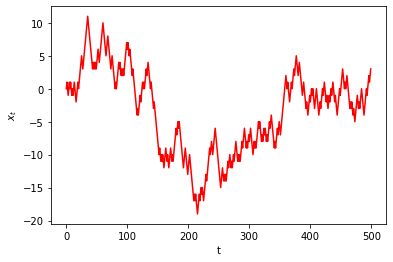

In [19]:
T = 500
x_t = np.zeros(T) #initializing the data as an all zero vector

def coin_flip():
    flip = np.random.randint(0,2) #generates random number between 0 and 1
    if flip == 0:
        return 1
    if flip == 1:
        return -1

for i in range(T - 1):
    x_t[i+1] = x_t[i] + coin_flip() #playing the game: if flip == 0, goes backwards, if flip == 1, goes forward
    
plt.plot(x_t,color='red') #plotting the outcome
plt.xlabel('t')
plt.ylabel('$x_t$')

if x_t[T-1] > 0: #if final position is greater than zero, you win
    print('You win :)')
else: #if it's less you lose
    print('You lose :(')

This is an example of a stochastic process, where you cannot use $x_i$ to fully determine $x_{i+j}$ where $j > i$. In fact in this case, $x_{i}$ gives zero information about path to $x_{i+j}$. Although one could still ask questions such as "if I play this game 300 times, what is my expected return?". Well although the answer might be obvious to most, let us attempt it.


##### First, let us build a function that automates the code block above

In [20]:
def play_game():
    T = 500
    x_t = np.zeros(T) 

    def coin_flip():
        flip = np.random.randint(0,2) 
        if flip == 0:
            return 1
        if flip == 1:
            return -1

    for i in range(T - 1):
        x_t[i+1] = x_t[i] + coin_flip() 
        
    return x_t #returns an array where the i-th entry contains x_i

##### Now, let us plot 10 games (for visual purposes only)

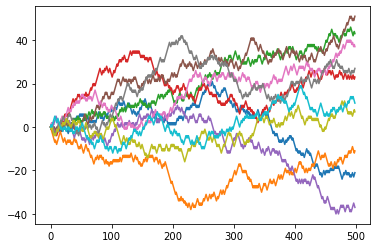

In [21]:
for _ in range(10):
    plt.plot(play_game())

##### Finally, let us see the mean return (expected outcome) of 300 games

In [22]:
final_pos = [play_game()[-1] for _ in range(300)] #dataset containing final position, x_T, for 300 games

mean_position = np.mean(final_pos) #<x_T>

print(mean_position)

-1.68


As you can see the average $x_{T = 500}$ is roughly 0, and therefore, as you likely expected, your mean return over a large number of games is roughly 0\%. Certainly not an investment one should consider for long term returns. One could also define risk by $\sigma$, which comes out to be 

In [23]:
risk = np.std(final_pos) #sigma
risk

21.318949317449956

which is $\approx \sqrt(T)$. 

A nice excercise is to vary various parameters in the `play_game()` function and study the output distributions of $x_T$ over multiple games. Also to generalize this game to several dimensions (i.e $n$ independent coins, each one corresponding to a certain spacial dimension -- although we're unfortunately limited to 3).

Another thing one may have noticed is that the graphs above look $\sim$ similar to e.g stock prices, which should make it clear why we study stochastic processes in finance.

### Formal definition

A stochastic process is a set of random variables $\{X_t\}_{t\in T}$ that is indexed in time, where $T$ is the set of all times in which an observation $X_t$ is made. It could be discrete (such as the example above) or continuous. An observation $X_t$ is defined as 

$$X_t: (\vec{\Omega}, \mathfrak{U}) \rightarrow(\mathbb{R}, \mathfrak{\beta)}$$


If it is discrete, then $T = \{0,\dots,n\}$ and if it is continuous, then $T \subseteq [0,\infty)$.


The state space $S$ is defined as the union of all possible outcomes given some variable $\Omega$, or

$$S = \cup_{t \in T}X_t(\vec{\Omega})$$


For example, if we were to play the coin game an infinite number of times, we would realize every element of the game's state space. For an arbitrary $\omega \in \vec{\Omega}$, a sample path or trajectory is given by 

$$T \rightarrow S: t \rightarrow X_t(\omega)$$

An example of a trajectory is given in the output of code block 18. 


A stochastic process is called _stationary_ if its joint probability distribution is invariant under a time transformation $t \rightarrow t + h$, or

$$(X_{t_1 + h},\dots, X_{t_n + h}) \sim (X_{t_1},\dots, X_{t_n})$$

with lag $h > 0$ and times $t_i, t_{i+h} \in T$. An example of a stationary process is what is known as white noise, a process where $\{X_t\}_{t\in \mathbb{Z}}$ is a sequence of independent random variables with similar distributions with $Var(x_t) = \sigma^2 \in [0,\infty)$ for all $t \in Z$. A white noise with $\mathbb{E}(X_t) = 0$ is named a _strict white noise process_ and is denoted by $\{X_t\}_{t \in \mathbb{Z}} \sim WN(0,\sigma^2)$.


Another type of stochastic process is called the _Markov Process_. In simplest terms, it is a process where the probability distribution of the "next" event is a function of only the present, not the past. i.e 

$$P(X_{t_n} \in B | X_{t_1} = x_{t_1}, \dots, X_{t_{n-1}} = x_{t_{n-1}}) = P(X_{t_n} \in B | X_{t_{n-1}} = x_{t_{n-1}})$$


where $0 \leq t_1 \leq t_2 \dots \leq t_n$, $x_i \in \mathbb{R}$ and $B \subseteq \mathbb{R}$


The statement above essentially states that if the process is a Markov process, $X_{t_i} = x_{t_i}$ holds all the information one can have about $X_{t_{i+1}} = x_{t_{i}}$. A Markov process is called a Markov chain if it has a discrete index set or state space, i.e $X_{t+1}$ only depends on $X_{t}$

#### Python Implementation

Let's try to implement some white noise process by generating a random number $x_i \in (-1,1)$ 1000 times.

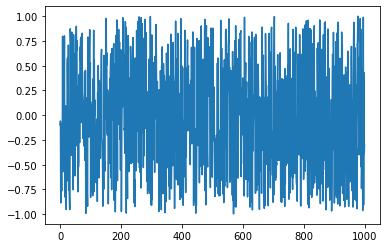

In [24]:
rng = lambda: np.random.uniform(-1,1) #random number generator

plt.plot([rng() for i in range(1000)]) #applying the rng 1000 times and plotting it

Bonus points if you map a given number to a color, and make produce a video of a set of pixels undergoing white noise. Also try to simulate a markov process.

 #### Increment types
 - A stochastic process is said to have stationary increments if 
 
 $$X_t - X_s \sim X_{t + h} - X_{s+h}$$
 
 - A stochastic process is said to have independent increments if the increments
 
 $$X_{t_i} - X_{t_{i - 1}}$$
 are stochastically independent for all $i$
 
 
 #### Weiner Process
 
 
 I conclude the coin game example above by stating that its trajectory visually resembles that of a stock price, and that the evolution of stock prices are typically modeled as a stochastic process. A very notable type of stochastic process used to model stock prices (amongst many other things) are Weiner Processes. 
 
 A Stochastic Process is said to be a Weiner Process (or  said to follow Brownian Motion) if 
 
  - $X_{t_1} - X_{t_0}, X_{t_2} - X_{t_1}, \dots, X_{t_n} - X_{t_{n-1}}$ are stochastically independent for all $t_i$
  - The incrememnts of $X_{t + h} - X_{t}$ are stationary
  - The increments are normally distributed, i.e
  
  $$X_t - X_s \sim N(\mu(t - s), \sigma^2(t - 2))$$
  
  where $s < t$, $\mu(t - s)$ is named the _drift_ and $\sigma^2(t - s)$ is named the _diffusion_
  
  It could be written as
  
  $$X_t = w_0 + \mu t + \sigma\sqrt{t}Z_t$$
  
  with $Z_t \sim N(0,1)$. This should make the definition above more clear. 
  
- The covariance of this process is

$$X_s, X_t = \min\{s,t\}\sigma^2$$

- The expected value is $$\mathbb{E}(X_t) = w_0 + \mu t$$

- And the standard deviation is 

$$\sqrt{Var(X_t)} = \sigma\sqrt{t}$$
   

#### Python Implementation
   A special case of the Weiner process is denoted by $W(w_0 = 0, \mu = 0, \sigma = 1)$ and is named the _Standard Weiner Process_. Let us try to use python and generate one.
   
   Given that $w_0 = 0, \mu = 0, \sigma = 1$, we can show that 
   
   $$X_t = \sqrt{t}Z_t$$

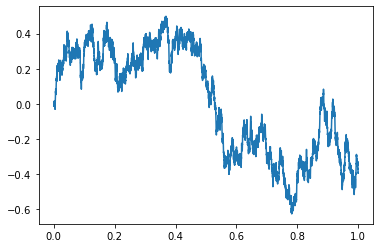

In [25]:
t_vals = np.linspace(0,1,10000) #t ɛ [0,1] discertized with 10,000 entries

X = np.zeros(10000) #initializing X at an all zero array

for i in range(10000-1):
    X[i+1] = X[i] + (np.random.normal()*np.sqrt(t_vals[1] - t_vals[0])) #X_t = sqrt(t)*Z_t, where Z_t ~ N(0,1)


plt.plot(t_vals,X) #plotting the Weiner process


Let us generalize this to create a Weiner function, `weiner_plotter(w0, mu, sigma)`

In [26]:
def weiner_plotter(w0 = 0,mu = 0,sigma = 1):
    n=1000 #number of entries
    t_vals = np.linspace(0.0001,1,n) #T
    
    X = np.zeros(n) #initialization of X
    t = t_vals[1] - t_vals[0] #t
    X[0] = w0 #X_0 = w0
    
    for i in range(n-1):
        X[i+1] = X[i] + mu*t + sigma*np.random.normal()*np.sqrt(t) #X_t = w0 + mu*t + sigma*sqrt(t)*Z_t

    return plt.plot(t_vals,X,label='$w_0 = $'+str(w0)+", $\mu = $"+str(mu)+". $\sigma =$"+str(sigma))

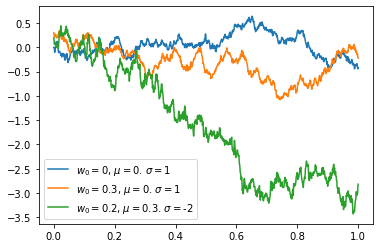

In [27]:
weiner_plotter()
weiner_plotter(0.3,0,1)
weiner_plotter(0.2,0.3,-2)
plt.legend()

As one can tell from the shape of the graphs above, a Weiner trajectory, although continuous, is not differentiable, as it is missing smoothness. 

A Weiner process can also be described as a type of _Diffusion process_, or a stochastic process $(X_t)_{t \geq 0}$ that satisfies the following:

 1. $P(X_t \leq x_t | X_u \leq x_u, u \leq s) = P(X_t \leq x_t | X_s = x_s)$ (I.e it satisfies the Markov Property)
 2. $P(|X_t - X_s| > \epsilon |X_s = x_s) = o(t-s)$ where $o(t-s)/(t-s) \rightarrow 0$ for $t \rightarrow s$ (i.e large increments in short periods of time have small probabilities)
 3. $\mathbb{E}(X_t - X_s | X_s = s) = \mu(s,x)(t-s) + o(t - s)$
 4. $\mathbb{E}((X_t - X_s)^2 | X_s = x) = \sigma^2(s,x)(t-s) + o(t - s)$
 
The Weiner process could therefore be described as a diffusion process where $\mu(s,X_t) = \mu$ and $\sigma(s,X_t) = \sigma$.


Something to note is that usually, we're not only interested in modeling $X_t$ but rather also with modeling some function of $X_t$, $f(t,X_t)$. A notable statement about functions of stochastic processes is known as _Ito's Lemma_, and it states the following:


<hr>
If  $(X_t)_{t \geq 0}$ is a diffusion process (and certain conditions are met), then a function of $X_t$, $f(t,X_t)$ is also a diffusion process with drift $\frac{\partial f}{\partial x}\mu + \frac{\partial f}{\partial t} + \frac{\partial ^2 f}{\partial x^2}\sigma^2$ and volatility $\frac{\partial f}{\partial x}\sigma$
<hr>

#### A Crash Course In Stochastic Calculus

A diffusion process $X_t$ can be written as a stochastic differential equation (SDE) in the following way:

$$dX_t = \mu(t,X_t)dt + \sigma(t,X_t)dW_t$$

where $W_t$ represents a standard weiner process and $d\rho$ reads out "the change in $\rho$".  As per _Ito's Lemma_, one can similarly describe a function of a process $f(t,X_t)$ as 

$$df(t,X_t) = \frac{\partial f}{\partial x}\mu + \frac{\partial f}{\partial t} + \frac{\partial ^2 f}{\partial x^2}\sigma^2dt + \frac{\partial f}{\partial x}\sigma dW_t$$


Solving such equations usually requires one writing the SDE in the following form:

$$X(t) = X(0) + \int_0^t \mu(s,X(s))ds + \int_0^t \sigma(s,X(s))dW(s)$$

Looking at the equation above, one can likely make sense of the first two terms, the first being the initial conditions, and the second being a standard deterministic _Reimann_ integral. The third term, however, seems a little more complicated as we are integrating a function with respect to a weiner process. This type of term is known as an _Ito_ integral or a stochastic integral, and is generally written as 


$$\mathcal{I} = \int_0^t X(t) dW(t)$$

where $X(t)$ is some stochastic process and $dW(t)$ represents some infinatesimal change in a Standard Weiner Process $W(t)$. Such an integral is constructed by splitting the interval $[0,t]$ into $n$ sub-intervals $[t_i,t_{i+1}]$ and taking 

$$\mathcal{I}_n(t) = \sum_i X(t_i)[W(t_{i+1} - W(t_i))]$$


where as $\mathbb{E}[(\mathcal{I}_n(t) - \mathcal{I}(t))^2] \rightarrow 0$, one will get closer to the ito integral $\mathcal{I}$. This becomes more intuitive if one thinks of its similarity to the construction deterministic integrals (i.e the _Riemann-Stieltjes_ integral, which takes form $\int f(x)dg(x)$)


#### Geometric Brownian Motion 

A Stochastic Process $(S_t)_{t \geq 0}$ is said to follow Geometric Brownian Motion (GBM) if the following applies:

$$S_t = S_0e^{(\mu - 1/2\sigma^2)(t-t_0) + \sigma(W_t - W_0)}$$


The logarithm of this process is simply a Weiner Process (or a process that follows Brownian Motion). In differential notation, a GBM process is written as follows:

$$dS_t = \mu S_tdt + \sigma S_tdW_t$$

or 

$$d(\log{S_t}) = mdt + \sigma dW_t$$

where $m = \mu - \sigma^2 / 2$.

In many areas of finance (notably the Black-Scholes model in option pricing), the price of a stock is assumed to follow geometric brownian motion (i.e $d(\log S_t)$ represent log returns), where $m$ represents the continuous-time mean return is, and $\mu$ the discrete mean return. This was briefly commented on early in this notebook (see Log-Normal Distributions).


The relative change of $S_t$ over a time period $[t, t + \Delta t]$ is 

$$\frac{\Delta S}{S} = \frac{S_{t + \Delta t} - S_t}{S_t} = \frac{S_{t + \Delta t}}{S_t} - 1$$

which, because $S_t$ is lognormally distributed, the quotient is also log-normally distributed, giving us

$$\frac{\Delta S}{S} = e^{m\Delta t + \sigma \sqrt{\Delta t}Z} - 1$$

where $Z \sim N(0,1)$. 


The log returns are defined by $U_t = \log{S_t/S_{t-1}} \sim N(m, \sigma^2)$ (i.e they're iid normally distributed). By this definition, we can propose the following way to simulate a (discrete) GBM process:

$$S_n = S_0\prod_{i = 1}^n e^{U_i}$$

which we will implement in python bellow: 

#### Python Implementation

In [434]:
def gbm_path(S0=1,m=0,sigma_sqrd=0.1,n=100):
    
    S = np.zeros(n) #intializing the path
    S[0] = S0 #initial conditions
    
    for i in range(n-1):
        S[i+1] = S[i]*np.exp(np.random.normal(m,sigma_sqrd)) #implementing the 
    return S

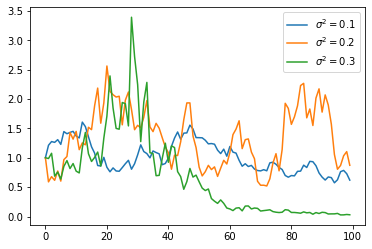

In [481]:
for i in range(1,4):
    plt.plot(gbm_path(sigma_sqrd=0.1*i),label='$\sigma^2 = $'+str(round(0.1*i,2))) #keeping everything constant but linearly varying volatility
plt.legend()

Using the simple code above, we have implemented a Geometric Brownian Motion path generator. 

Another task that is worth implemeting is stochastic integration, which we will again build a function for. 

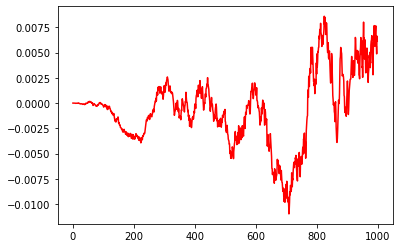

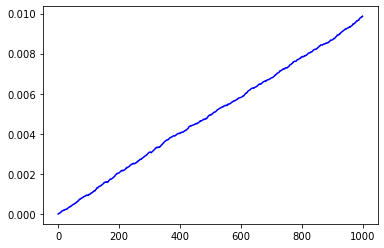

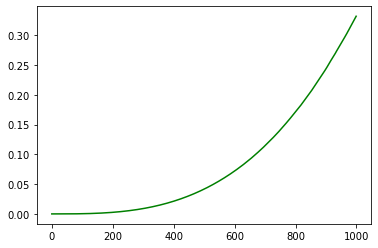

In [548]:
#NOTE: this has been lifted from tch on https://stackoverflow.com/questions/33053940/stochastic-integration-with-python

def ito_int(mu,sigma,x0,T): #mu(t,X_t) and sigma(t,X_t) are functions, x0 is the initial condition, T are the times
    N = len(T) #number of timesteps
    
    I = np.zeros((N,len(x0)))#initalization
    I[0] = x0 #intial conditions
    for i in range(N-1):
        dt = T[i+1]-T[i] #timestep length
        dWt = np.random.normal(0,dt) #weiner change
        I[i+1] = I[i] + mu(T[i],I[i])*dt + sigma(T[i],I[i])*dWt #the integral according to eq above
    return I


plt.plot(ito_int(lambda x,y: x*y,lambda x,y: x,[0],np.linspace(0,1,1000)),color='red') #mu=t*X_t, sigma = t
plt.show()
plt.plot(ito_int(lambda x,y: 1/100,lambda x,y: 1/100,[0],np.linspace(0,1,1000)),color='blue') #mu=1/100, sigma = 1/100
plt.show()
plt.plot(ito_int(lambda x,y: x**2,lambda x,y: y**2,[0],np.linspace(0,1,1000)),color='green') #mu=t^2, sigma = X_t^2
plt.show()


As you can see, for different drift $\mu(t,X_t)$ and different volatility $\sigma(t,X_t)$ we get very different results. 

#### Multivariate Brownian Motion


A univariate Weiner process can be generalized into a multivariate process $\vec{W}(t)$ as follows:


$$\vec{W}(t) = \begin{pmatrix}W_1(t)\\W_2(t)\\ \vdots \\ W_n(t)\end{pmatrix}$$

Here, the components $W_i(t)$ represent univariate Weiner processes which are pairwise stochastically independent. Analogously to the 1-d case, for the $n$-d case, the following holds:


$$\vec{W}(t) - \vec{W}(s) \sim N_n(\vec{0},\mathbf{I})$$

where $\vec{0}$ is an $n$-dimensional all zero vector and $\mathbf{I}$ is the $n \times n$ identity matrix.

The multivariate stochastic process $X_t$ could also be expressed as the SDE

$$d\vec{X}(t) = \vec{m}dt + \mathbf{H}d\vec{W}(t)$$

where $\vec{m} = (m_1, \dots, m_n)$ and $\mathbf{H}$ is a matrix such that $\mathbf{\Sigma} = \mathbf{H}\mathbf{H}^T$. The SDE can be equivalently written as 

$$\vec{X}(t) = \int_{t_0}^t\vec{m}dt + \int_{t_0}^t\mathbf{H}d\vec{W}(t)$$

In the example of an $n$-dimensional Weiner process, this solves to be the following:

$$\vec{X}(t) = \vec{m}(t - t_0) + \sqrt{t - t_0}\mathbf{HZ}(t)$$

with $\mathbf{Z}(t) \sim N_n(\vec{0},\mathbf{I})$.

The result is 

$$\vec{X}(t) - \vec{X}(s) \sim N_n(\vec{m}(t - s), (t - s)\mathbf{\Sigma})$$

with $\mathbf{\Sigma}$ being the covariance matrix

#### Multivariate Geometric Brownian Motion

Similar to above, the $n$-dimensional generalization of GBM is the following:


$$\log(\vec{S}(t)) = \begin{pmatrix}\log(S_1(t))\\\log(S_2(t))\\ \vdots \\ \log(S_n(t))\end{pmatrix}$$


which can be written as the following SDE:

$$d(\log{\vec{S}(t)}) = \vec{m}dt + \mathbf{H} d \vec{W}(t)$$

The log returns of the a process that follows MGBM follow a multivariate normal distribution $N_n(\vec{n},\mathbf{\Sigma})$ and the individual returns are stochastically independent (meaning that in cases where there is dependence, one would need to assume a more complicated model than MGBM).